# Hate Speech Recognition using AI

This notebook consists the code for the development of a Hate Speech Recognition using AI. The data used for this project is Hate Speech dataset taken from Kaggle: https://www.kaggle.com/datasets/mrmorj/hate-speech-and-offensive-language-dataset.

The notebook includes:

*   Exploratory Data Analysis
*   Data Cleaning and Preperation
*   Feature Generation
*   Model Development
*   Evaluation

# Set-Up

The noteboook ensures that all the libraries needed to execute the code are installed. Kaggle aAPI token is needed to download the data from the website.

In [1]:
%%capture
!pip install kaggle
!pip install contractions

In [2]:

# Upload Kaggle API token: generate it through the kaggle account
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"b1d9a154ac61407aa981","key":"eebe0bdd7e7eda464670a241866e9455"}'}

In [3]:
%%capture
# Ensure the kaggle.json is in the right folder
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
%%capture
# Download the dataset from Kaggle
!kaggle datasets download -d mrmorj/hate-speech-and-offensive-language-dataset

In [5]:
%%capture
# Unzip the downloaded dataset
!unzip hate-speech-and-offensive-language-dataset.zip

In [6]:
%%capture
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

import contractions
import re

# 1. Exploratory Data Analysis

Goal: Check for null values, understand the structure, and inspect the data distribution.


In [7]:
df = pd.read_csv('labeled_data.csv')

In [8]:
print("Shape of the dataset:", df.shape)


Shape of the dataset: (24783, 7)


In [9]:
print("\nFirst 5 rows of the dataset:\n", df.head())



First 5 rows of the dataset:
    Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0           0      3            0                   0        3      2   
1           1      3            0                   3        0      1   
2           2      3            0                   3        0      1   
3           3      3            0                   2        1      1   
4           4      6            0                   6        0      1   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...  


The dataset has 7 columns where the **class column** labels the tweet as **hate speech(represented as 0), offensive language(represented as 1) and neither(represented as 2)**.

The tweet columns shows the actaul texts for the tweet. The text contains special chafracters such as exclamation marks, 'RT'; acronym for retweet. This is helpful information during the data cleaning process.

In [10]:
print("\nData types and null values:\n", df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB

Data types and null values:
 None


In [11]:

# Check for missing values
print("\nMissing values in each column:\n", df.isnull().sum())


Missing values in each column:
 Unnamed: 0            0
count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
dtype: int64



Class distribution:
 class
1    19190
2     4163
0     1430
Name: count, dtype: int64


<ipython-input-12-a3b33360ba8d>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Hate', 'Offensive', 'Neither'])


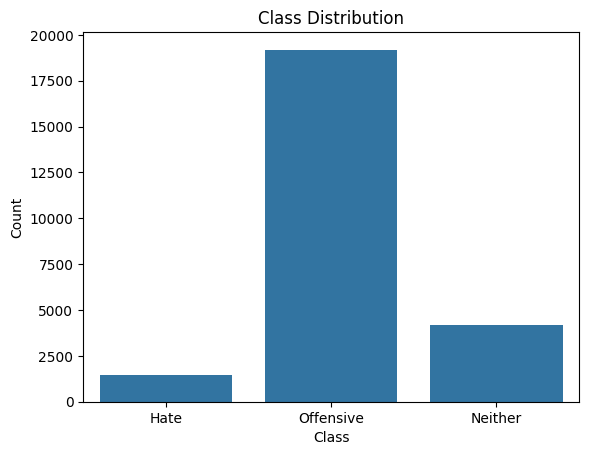

In [12]:
# distribution of classes
print("\nClass distribution:\n", df['class'].value_counts())

# Visualize the class distribution
ax = sns.countplot(x='class', data=df)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

# Set custom labels for the x-axis
ax.set_xticklabels(['Hate', 'Offensive', 'Neither'])

plt.show()

This shows that the dataset is unbalanced with a bias towards the label '1' or the offensive language tweets.

To mitigate this, the data can be augmented with simulated data or additional datasets. Equally we could try usingh SMOTE to address the imbalance in the dataset.

In [13]:
# augment the current dataset to have a more balanced distribution for the class labels
uploaded = files.upload()

Saving df_inoffensive.csv to df_inoffensive.csv


In [14]:
# read in the additional dataset
df_aug = pd.read_csv('df_inoffensive.csv')

df_aug = df_aug.drop(['clean_tweet'], axis=1)
df_aug.head()

,class,tweet
0,2,"I`d have responded, if I were going"
1,2,http://www.dothebouncy.com/smf - some shameles...
2,2,2am feedings for the baby are fun when he is a...
3,2,Soooo high
4,2,Journey!? Wow... u just became cooler. hehe....


In [15]:
# drop all columns except tweet and class
df = df.drop(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither'], axis=1)

# df['clean_tweet'] = df['tweet'].apply(clean_text)

df.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [16]:
df['class'] = df['class'].apply(lambda x: 0 if x in [0, 1] else 2)


In [17]:
df['class'].value_counts()

,count
class,
0,20620
2,4163


In [18]:
# combine the two dataframes
df_combined = pd.concat([df, df_aug], ignore_index=True)
# change the label for class 2 to 1
df_combined['class'] = df_combined['class'].replace(2, 1)
# check the class distribution
print(df_combined['class'].value_counts())


class
1    23789
0    20620
Name: count, dtype: int64


# 2. Data Pre-Processing

- Clean the text data: Remove special characters, stop words, and perform tokenization.
- Convert text to lowercase, handle contractions, and perform stemming or lemmatization.





In [20]:

def expand_contractions(text):
    expanded_words = []
    for word in text.split():
       expanded_words.append(contractions.fix(word))
    return ' '.join(expanded_words)

In [21]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

def clean_text(text, stop_words):
    # Expand contractions
    text = expand_contractions(text)

    # Remove 'RT'
    text = re.sub(r'\bRT\b', '', text)

    # Remove Twitter handles (@username)
    text = re.sub(r'@\S+', '', text)#

    # Remove hashtags
    text = re.sub(r'#\S+', '', text)

    # Remove URLs
    text = re.sub(r'https?:\S+', '', text)

    # Remove special characters and numbers
    text = re.sub(r'[^A-Za-z\s]', '', text)

    # Convert to lowercase
    text = text.lower()

    # Tokenize the text
    words = word_tokenize(text)

    # Remove stop words
    words = [word for word in words if word not in stop_words]

    # Perform lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]

    # Join the words back into a string
    cleaned_text = " ".join(words)

    return cleaned_text



In [22]:
# Step 1: Initial cleaning with base stop words
base_stop_words = set(stopwords.words('english'))
df_combined['cleaned_tweet'] = df_combined['tweet'].apply(lambda x: clean_text(x, base_stop_words))

Most common words: [('bitch', 11317), ('hoe', 4285), ('like', 3708), ('get', 2590), ('got', 2472), ('day', 2447), ('pussy', 2203), ('nigga', 1994), ('love', 1931), ('good', 1878), ('lol', 1868), ('want', 1711), ('going', 1677), ('know', 1650), ('go', 1616), ('as', 1570), ('one', 1501), ('fuck', 1446), ('im', 1339), ('time', 1295), ('shit', 1280), ('trash', 1152), ('back', 1121), ('see', 1108), ('happy', 1108), ('would', 1054), ('make', 1014), ('today', 1009), ('think', 999), ('really', 992), ('need', 975), ('work', 952), ('look', 928), ('girl', 919), ('still', 914), ('say', 898), ('new', 884), ('amp', 845), ('mother', 819), ('night', 802), ('though', 792), ('thanks', 772), ('people', 760), ('well', 746), ('bad', 741), ('right', 730), ('come', 709), ('man', 708), ('great', 667), ('hope', 667)]


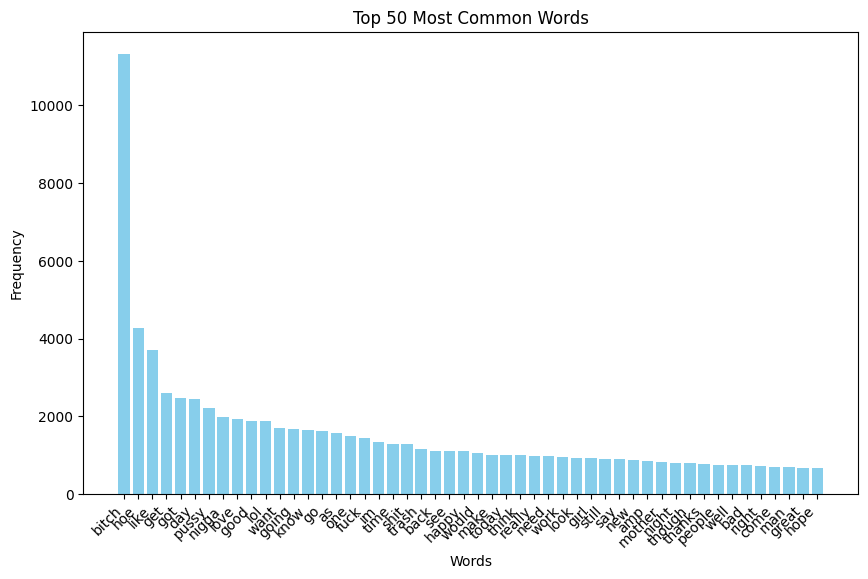

In [23]:
# Step 2: Perform frequency analysis
all_words = ' '.join(df_combined['cleaned_tweet']).split()
word_freq = Counter(all_words)
# most_common_words = word_freq.most_common(50)
# print("Most common words:", most_common_words)

most_common_words = word_freq.most_common(50)
print("Most common words:", most_common_words)
words, frequencies = zip(*most_common_words)
# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(words, frequencies, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 50 Most Common Words')
plt.show()

In [24]:
# Step 3: Update stop words with frequently occurring words that do not add value to the dataset
# Manually filter words to be added to stop words
non_informative_words = ['like', 'get', 'got', 'day', 'just', 'lol','one', 'know', 'going', 'time', 'can', 'go', 'as', 'one', 'im', 'see', 'would', 'still', 'say', 'new', 'amp', 'though', 'well']

# Update stop words with these non-informative words
updated_stop_words = base_stop_words.union(set(non_informative_words))

# Reapply cleaning with updated stop words
df_combined['cleaned_tweet'] = df_combined['tweet'].apply(lambda x: clean_text(x, updated_stop_words))

In [26]:
# Display the original and cleaned tweets
print(df_combined[['tweet', 'cleaned_tweet']].head())

                                               tweet  \
0  !!! RT @mayasolovely: As a woman you shouldn't...   
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...   
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...   
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...   
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...   

                                       cleaned_tweet  
0  woman complain cleaning house man always take ...  
1   boy dat coldtyga dwn bad cuffin dat hoe st place  
2       dawg ever fuck bitch start cry confused shit  
3                                        look tranny  
4     shit hear might true might faker bitch told ya  


In [27]:
df_combined = df_combined.drop(['tweet'], axis=1)


Class distribution with augmented data:
 class
1    23789
0    20620
Name: count, dtype: int64


<ipython-input-25-6bec812a7713>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([ 'Offensive', 'Inoffensive'])


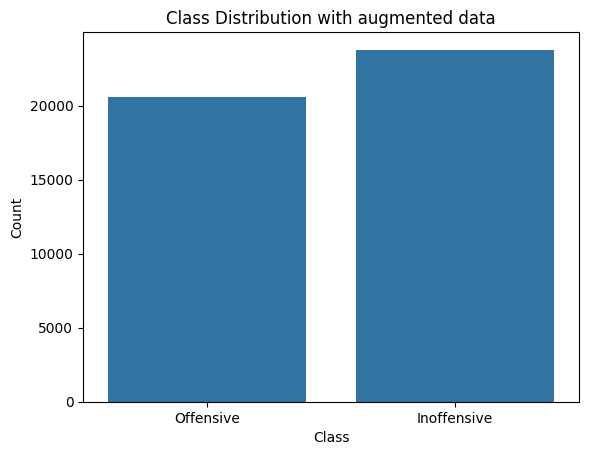

In [25]:
# distribution of classes
print("\nClass distribution with augmented data:\n", df_combined['class'].value_counts())

# Visualize the class distribution
ax = sns.countplot(x='class', data=df_combined)
plt.title('Class Distribution with augmented data')
plt.xlabel('Class')
plt.ylabel('Count')

# Set custom labels for the x-axis
ax.set_xticklabels([ 'Offensive', 'Inoffensive'])

plt.show()

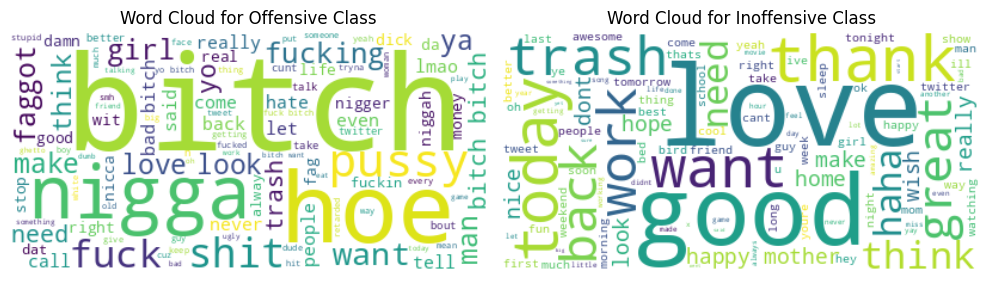

In [33]:
def plot_wordcloud(class_label):
    label_text = "Offensive" if class_label == 0 else "Inoffensive"
    text = " ".join(review for review in df_combined[df_combined['class'] == class_label].cleaned_tweet)
    wordcloud = WordCloud(max_words=100, background_color="white").generate(text)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'Word Cloud for {label_text} Class')

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plot_wordcloud(0)

plt.subplot(1, 2, 2)
plot_wordcloud(1)

plt.tight_layout()
plt.show()

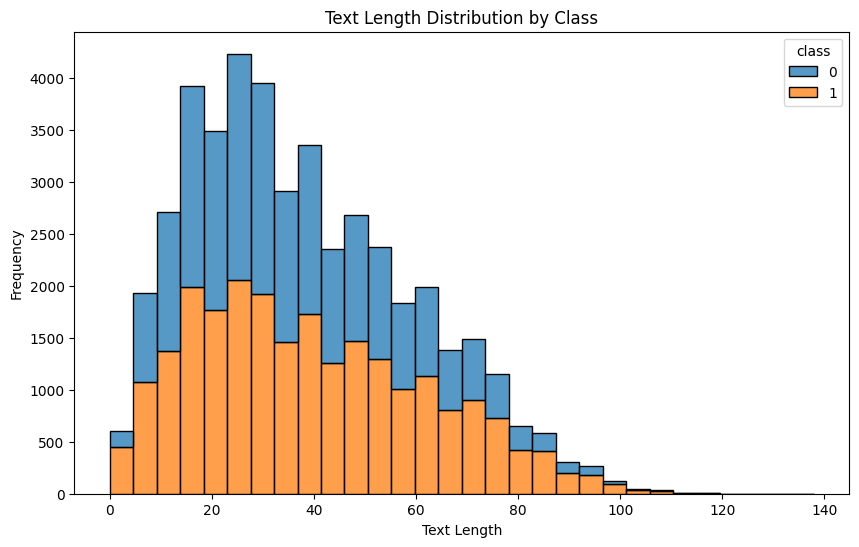

In [34]:
# Text Length Analysis
# Add a new column for text length
df_combined['text_length'] = df_combined['cleaned_tweet'].apply(len)

# Plot the distribution of text length for each class
plt.figure(figsize=(10, 6))
sns.histplot(data=df_combined, x='text_length', hue='class', multiple='stack', bins=30)
plt.title('Text Length Distribution by Class')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

<ipython-input-35-e0002ff00cdb>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis')


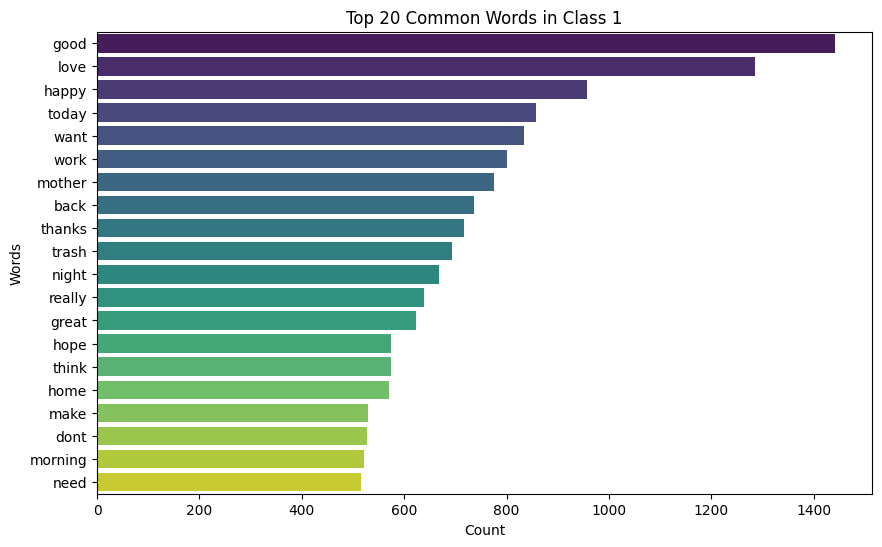

<ipython-input-35-e0002ff00cdb>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis')


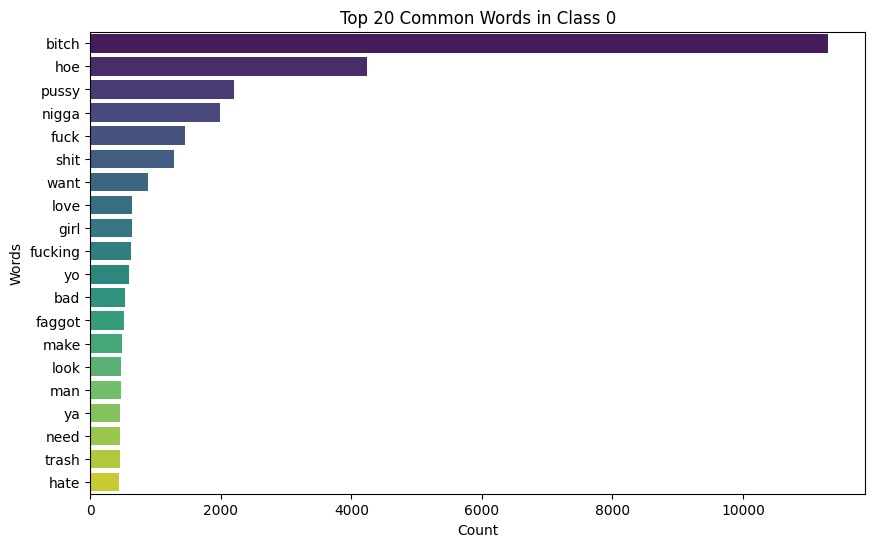

In [35]:
#  Common Words Analysis
# Function to get common words in each class

stop = set(stopwords.words('english'))

def get_common_words(class_label, n=20):
    text = " ".join(review for review in df_combined[df_combined['class'] == class_label].cleaned_tweet)
    words = [word for word in text.split() if word.lower() not in stop]
    common_words = Counter(words).most_common(n)
    return common_words

# for class_label in df['class'].unique():
#     common_words = get_common_words(class_label)
#     print(f"\nCommon words in Class {class_label}:\n", common_words)

# Function to plot common words
def plot_common_words(common_words, class_label):
    words, counts = zip(*common_words)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(counts), y=list(words), palette='viridis')
    plt.title(f'Top {len(common_words)} Common Words in Class {class_label}')
    plt.xlabel('Count')
    plt.ylabel('Words')
    plt.show()

# Apply the functions and plot
for class_label in df_combined['class'].unique():
    common_words = get_common_words(class_label)
    plot_common_words(common_words, class_label)

# 3. Model Training

This script tests two different methods:
- TF-IDF with Logistic Regression

- Fine-tuning BERT

**TF-IDF with Logistic Regression**

In [ ]:
# TF-IDF with Logistic Regression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize the vectorizer
vectorizer = TfidfVectorizer(max_features=1000)

# Fit and transform the cleaned text data
X = vectorizer.fit_transform(df_combined['cleaned_tweet'])

# Convert to an array if needed
X_array = X.toarray()

# Check the shape of the transformed data
print(X_array.shape)

# Assuming 'class' is the target variable
y = df_combined['class']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the training set into training and validation sets if needed
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Initialize the model
logreg_model = LogisticRegression(max_iter=1000)

# Train the model
logreg_model.fit(X_train, y_train)

(44409, 1000)


In [ ]:
# Evaluating performance on validation dataset

# Predict on the validation set
y_val_pred = logreg_model.predict(X_val)

# Calculate evaluation metrics
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred, average='weighted')
recall = recall_score(y_val, y_val_pred, average='weighted')
f1 = f1_score(y_val, y_val_pred, average='weighted')

print(f'Validation Accuracy: {accuracy}')
print(f'Validation Precision: {precision}')
print(f'Validation Recall: {recall}')
print(f'Validation F1 Score: {f1}')

Validation Accuracy: 0.9650979509119567
Validation Precision: 0.9660023884025846
Validation Recall: 0.9650979509119567
Validation F1 Score: 0.9650127524025865


**Fine-tuning BERT**

In [ ]:
%%capture
!pip install transformers
!pip install torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
# fine-tuning BERT
from sklearn.model_selection import train_test_split

# Assuming 'class' is the target variable
X = df_combined['cleaned_tweet'].tolist()
y = df_combined['class'].tolist()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_data(text_list):
    return tokenizer(text_list, padding=True, truncation=True, max_length=128, return_tensors='pt')

# Tokenize the training and validation data
train_encodings = tokenize_data(X_train)
val_encodings = tokenize_data(X_val)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = TextDataset(train_encodings, y_train)
val_dataset = TextDataset(val_encodings, y_val)


In [ ]:
from transformers import BertForSequenceClassification, AdamW

# Load BERT with a classification head
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)  # Adjust num_labels based on your dataset

# Move the model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
bert_model.to(device)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
from torch.utils.data import DataLoader
from transformers import get_linear_schedule_with_warmup

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Initialize the optimizer
optimizer = AdamW(bert_model.parameters(), lr=5e-5)

# Scheduler
total_steps = len(train_loader) * 4  # 4 epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
epochs = 4

for epoch in range(epochs):
    bert_model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = bert_model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()

    print(f'Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}')

    bert_model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = bert_model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()
            predictions = torch.argmax(outputs.logits, dim=-1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    print(f'Validation Loss: {val_loss / len(val_loader)}, Accuracy: {correct / total}')


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-49-7ae742b01e28>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 1, Loss: 0.0683236197681537
Validation Loss: 0.08866657148060479, Accuracy: 0.9717405989641973
Epoch 2, Loss: 0.04471486387433646
Validation Loss: 0.10414026370165257, Accuracy: 0.9736545823012835
Epoch 3, Loss: 0.025753301294607876
Validation Loss: 0.09959776426050745, Accuracy: 0.975455978383247
Epoch 4, Loss: 0.014915092377495717
Validation Loss: 0.11843374557604698, Accuracy: 0.9753433911281243


In [ ]:
from sklearn.metrics import classification_report

bert_model.eval()
val_predictions = []
val_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = bert_model(input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=-1)
        val_predictions.extend(predictions.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

print(classification_report(val_labels, val_predictions, target_names=['Non-Offensive', 'Offensive']))


<ipython-input-49-7ae742b01e28>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


               precision    recall  f1-score   support

Non-Offensive       0.98      0.97      0.97      4117
    Offensive       0.97      0.98      0.98      4765

     accuracy                           0.98      8882
    macro avg       0.98      0.97      0.98      8882
 weighted avg       0.98      0.98      0.98      8882



# Evaluation

All the trained models were then evaluated on an external test dataset taken from the Hugging Face dataset library; Ethos Binary test data.

In [ ]:
%%capture
!pip install datasets


In [ ]:
!pip cache purge
!pip install pyarrow

!pip show pyarrow


Files removed: 3057
Name: pyarrow
Version: 15.0.2
Summary: Python library for Apache Arrow
Home-page: https://arrow.apache.org/
Author: 
Author-email: 
License: Apache License, Version 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: numpy
Required-by: bigframes, cudf-cu12, datasets, db-dtypes, ibis-framework, pandas-gbq, tensorflow-datasets


In [ ]:
from datasets import load_dataset
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

# Load the Ethos binary dataset
# ethos = load_dataset('ethos', split='binary')
ethos = load_dataset('ethos', split='binary', use_pyarrow=False)

# View the dataset
print(ethos)

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
import requests
import pandas as pd

# URL of the dataset on the Hugging Face Hub
url = "https://huggingface.co/datasets/ethos/resolve/main/binary.csv"

# Download the dataset
response = requests.get(url)

# Load the dataset into a Pandas DataFrame
df = pd.read_csv(response.content.decode('utf-8'))

# View the DataFrame
print(df.head())

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
ethos_texts = ethos['text']

base_stop_words = set(stopwords.words('english'))
ethos_cleaned_texts = [clean_text(text, base_stop_words) for text in ethos_texts]
ethos_cleaned_texts = [clean_text(text, updated_stop_words) for text in ethos_texts]

# Encode the labels
label_encoder = LabelEncoder()
ethos_labels = label_encoder.fit_transform(ethos['label'])


In [ ]:
## Evaluating logistic regression

# Initialize the vectorizer
vectorizer = TfidfVectorizer(max_features=1000)

# Fit and transform the cleaned text data
ethos_features = vectorizer.fit_transform(ethos_cleaned_texts)

# Convert to an array if needed
ethos_features_array = ethos_features.toarray()

# Check the shape of the transformed data
print(ethos_features_array.shape)

ethos_predictions = logreg_model.predict(ethos_features_array)

accuracy = accuracy_score(ethos_labels, ethos_predictions)
precision = precision_score(ethos_labels, ethos_predictions)
recall = recall_score(ethos_labels, ethos_predictions)
f1 = f1_score(ethos_labels, ethos_predictions)

print("Ethos test set perfomance metrics on TF_IDF and logistic regression:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")